In [1]:
import warnings
warnings.filterwarnings("ignore")

# Importing Basic libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./YoutubeCommentsDataSet.csv')
df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [4]:
df.duplicated().sum()

531

In [5]:
df.isnull().sum()

Comment      44
Sentiment     0
dtype: int64

In [6]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [7]:
print(f"Percent of values to drop in the dataset: {round((44+531) / len(df), 3) * 100}%")

Percent of values to drop in the dataset: 3.2%


Since the missing values are just less than 4% of the original dataset, we can just drop it

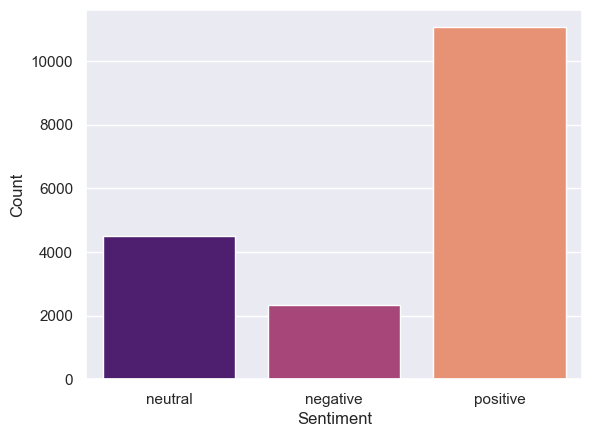

In [9]:
sns.set_theme(style='darkgrid')
sns.countplot(data = df, x = 'Sentiment', hue='Sentiment', palette='magma')
plt.ylabel("Count")
plt.show()

In [10]:
df['Sentiment'].replace({'positive': 2, 
                         'negative': 0,
                         'neutral': 1}, inplace=True)

df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,1
1,here in nz 50 of retailers don’t even have con...,0
2,i will forever acknowledge this channel with t...,2
3,whenever i go to a place that doesn’t take app...,0
4,apple pay is so convenient secure and easy to ...,2


# MODEL TIME!!!

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split as tts 
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay

x_train, x_test, y_train, y_test = tts(df['Comment'], df['Sentiment'], test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize the dataset properly
def tokenize_data(texts, labels, tokenizer, max_length=256):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset

# Tokenize the dataset
train_dataset = tokenize_data(x_train, y_train, tokenizer)
test_dataset = tokenize_data(x_test, y_test, tokenizer)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load pre-trained BERT model for classification
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Define optimizer and loss function
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.05)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
# Train the model with class weights and batch size of 1
model.fit(train_dataset.batch(2), 
          validation_data=test_dataset.batch(2), 
          epochs=3, 
          class_weight=class_weights_dict)